In [1]:
%matplotlib inline  
import re
import pandas as pd
import boto3
import unicodedata
import os
import collections
import functools
import nltk
from nltk.corpus import stopwords
import graphviz as gv

import matplotlib.pyplot as plt
import gensim
import pyLDAvis.gensim as gensimvis
import pyLDAvis
from gensim import models
from gensim.corpora import Dictionary, MmCorpus
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet
from gensim.corpora import Dictionary

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/andrea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Análisis de Texto de Programas Sociales

En México existen alrededor de 5,491 programas sociales a nivel federal, estatal y municipal lo cual conlleva a varios retos en cuanto a coordinación entre los distintos niveles e instituciones. Al no existir suficientes mecanismos para compartir información homogénea y sistematizada sobre los objetivos, acciones y  beneficiarios, se pueden llegar a observar programas similares o esfuerzos duplicados. 

Con el objetivo de conocer y entender los distintos programas sociales, sus temáticas y similitudes, se realizó un análisis utilizando procesamiento de texto y aprendizaje no supervisado utilizando la información de los objetivos de cada programa. El análisis fue realizado para 43 de los 149 programas sociales a nivel federal; sin embargo, el estudio puede ser fácilmente replicable y robusto para incluir más programas. 
 

## Metodología

En este estudió se utilizaron herramientas y modelos de análisis de texto, el cual es utilizado para generar análisis de documentos y en especial utilizado para:

* Recuperación de información
* Clustering y Categorización de Texto
* Resumir información
* Visualización

Existen diferentes paradigmas para realizar análisis de texto como generación de reglas de palabras, generación de reglas lingüísticas o gramaticales que implican cierto grado de conocimiento léxico importante y métodos de aprendizaje de máquina. Actualmente, los métodos de aprendizaje de máquina y estadística han sido fuertemente utilizados ya que  aproveche las estructuras lógicas y gramaticales del texto con buenos resultados. El enfoque más común es el Procesamiento de Texto Natural el cual será descrito en este documento y los pasos pueden describirse en el diagrama siguiente:



In [23]:
# Generate graph
graph = functools.partial(gv.Graph, format='png')
digraph = functools.partial(gv.Digraph, format='png')

styles = {
    'graph': {
        'fontsize': '16',
    },
    'nodes': {
        'fontname': 'Helvetica',
        'shape': 'oval',
        'fontcolor': 'white',
        'color': 'white',
        'style': 'filled',
        'fillcolor': 'darkcyan',
    },
    'edges': {
        'color': 'grey',
        'arrowsize': '2.5',
        'fontcolor': 'grey',
    }
}

def add_nodes(graph, nodes):
    for n in nodes:
        if isinstance(n, tuple):
            graph.node(n[0], **n[1])
        else:
            graph.node(n)
    return graph

def add_edges(graph, edges):
    for e in edges:
        if isinstance(e[0], tuple):
            graph.edge(e[0], **e[1])
        else:
            graph.edge(*e)
    return graph


def apply_styles(graph, styles):
    graph.graph_attr.update(
        ('graph' in styles and styles['graph']) or {}
    )
    graph.node_attr.update(
        ('nodes' in styles and styles['nodes']) or {}
    )
    graph.edge_attr.update(
        ('edges' in styles and styles['edges']) or {}
    )
    return graph


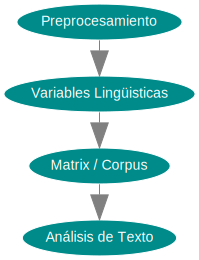

In [3]:
g = add_edges(
    add_nodes(digraph(), [
        ('A', {'label': 'Preprocesamiento'}),
        ('B', {'label': 'Variables Lingüisticas'}),
        ('C', {'label': 'Matrix / Corpus'}),
        ('D', {'label': 'Análisis de Texto'})
    ]),
    [
        ('A', 'B'),
        ('B', 'C'),
        ('C', 'D')
    ]
)
g = apply_styles(g, styles)
g

### Glosario

* **Corpus:** El corpus es el conjunto de todos los archivos/textos utilizadas para el análisis.    
* **Tokenize:** Es el proceso en el que el texto es separado en frases o términos útiles, en la mayoría de los casos es el proceso de separar las palabras por espacios en blanco. Sin embargo, puede ser más complicado automatizar para grupos o conjunto de palabras que constituyen frases.    
* **Stemming:** Es el proceso de normalización del texto reduciendo las palabras y conjugaciones a la raíz o forma más básica de la palabra. Esta normalización puede hacerse de forma sencilla eliminando sufijos y prefijos, actualmente existen nuevos métodos que pueden convertir palabras como hecho/hacer a una misma raíz.    
* **TF-IDF:** TF-IDF (term frequency-inverse document frequency), es un métodos que sirve para darle mayor peso a palabras que se repiten más en un mismo documento con relación a los demás documentos.    
* **Stop Words:** Es la lista de palabras que tienen poco significado semántico pero ocurren muy frecuentemente, como preposiciones, artículos, pronombres.

In [4]:
def notempty(string):
    """
    Checks if string exists
    if it does no exists returns an empty string
    
    :params: string to check
    :rtype: str
    """
    if string:
        return string
    else:
        return ''

def obj_esp_union(row):
    """
    Function that concatenates all general and specific objetives
    of each subprogram
    
    :param: row of a dataframe
    
    :returns: text_union
    :rtype: string
    """
    text_union = ("""{subprograma} {obj_g1} {obj_e1} {obj_e2} {obj_e3} {obj_e4} {obj_e5} {pob_obj} 
                    """.format(subprograma=notempty(row['nombre_subprograma']),
                               obj_g1=notempty(row['obj_gral_prog_1']),
                               obj_e1=notempty(row['obj_esp_prog_1']),
                               obj_e2=notempty(row['obj_esp_prog_2']),
                               obj_e3=notempty(row['obj_esp_prog_3']),
                               obj_e4=notempty(row['obj_esp_prog_4']),
                               obj_e5=notempty(row['obj_esp_prog_5']),
                               pob_obj=notempty(row['pob_obj_prog'])
                              ))
    return text_union

def all_objetivos_union(rows):
    """
    Concatenates all rows of subprogramas to have
    only one text for the programa
    
    :param: rows of dataframe
    :rtype: string
    """
    nombres = [x for x in rows['nombre_programa']]
    nombres = " ".join(list(set(nombres)))
    objetivos_grales = [x for x in rows['obj_gral_prog_1']]
    objetivos_grales = " ".join(list(set(objetivos_grales)))
    
    return nombres + ' ' + objetivos_grales + ' ' + " ".join(rows['objetivos_especificos'])

In [5]:
def clean_strings(var_string):
    """
    Function that cleans strings removing digits and simbols   
    :params: var_string string to clean
    :rtype: str
    """
    if isinstance(var_string, str):
        var_string = re.sub(r'[^\w\s]','',var_string)
        sub_string = " ".join(re.findall("[a-zA-Z]+", var_string))
        return sub_string.strip()

def clean_and_lower(var_string):
    """
    Function that calls function for cleaning
    and returns them in lower case
    
    :params: var_string string to clean
    :rtype: str
    """
    var_string = strip_accents(var_string)
    if isinstance(var_string, str):
        return clean_strings(var_string).lower()


def strip_accents(var_string):
    """
    Function that removes accents on a string
    
    :params: var_string string to clean
    :rtype: str
    """
    return ''.join(c for c in unicodedata.normalize('NFD', var_string)
                   if unicodedata.category(c) != 'Mn')

## Base de Datos

El análisis se realizó para 43 programas sociales federales juntando la información de los objetivos generales y objetivos específicos para cada subprograma (DOF). Se tuvo que unir los objetivos generales y específicos de todos los subprogramas pertenecientes a cada programa para realizar el análisis a nivel programa. A continuación se muestra la base de datos que se utilizó en donde viene cada subprograma en un renglón y cada objetivo en una columna.

In [27]:
# Leer archivo
s3_file = 'https://s3-us-west-2.amazonaws.com/sedesol-open-data/cuaps_sedesol.csv'
programas = pd.read_csv(s3_file)
programas.tail(3)

,dependencia,cve_programa,cve_padron,nombre_programa,nombre_subprograma,unidad_responsable,poblacion_objetivo,tipo_de_apoyo,obj_gral_prog_1,obj_esp_prog_1,obj_esp_prog_2,obj_esp_prog_3,obj_esp_prog_4,obj_esp_prog_5,pob_obj_prog,cuaps2017,observaciones,actualizacion_sedesol
76,ENNOSEC,S178,0092,Apoyo a la Educacion Indigena,Becas de Educacion Superior y Apoyo a Titulacion,NaN,NaN,NaN,Apoyar la permanencia en la educación de niños...,Brindar servicio de hospedaje a los beneficiar...,Brindar servicios de alimentación a los benefi...,Apoyar con alimentación y artículos de higiene...,"Fomentar la permanencia, continuidad, conclusi...",NaN,Estudiantes indígenas de 5 a 29 años que se en...,SI,NaN,2017-08-04 00:00:00
77,ENNOSEC,S178,0085,Apoyo a la Educacion Indigena,Casa y Comedor del Nií±o Indí­gena,NaN,NaN,NaN,Apoyar la permanencia en la educación de niños...,Brindar servicio de hospedaje a los beneficiar...,Brindar servicios de alimentación a los benefi...,Apoyar con alimentación y artículos de higiene...,"Fomentar la permanencia, continuidad, conclusi...",NaN,Estudiantes indígenas de 5 a 29 años que se en...,SI,NaN,2017-08-04 00:00:00
78,SEMARNAT,S219,0172,Apoyos para el Desarrollo Forestal Sustentable,Pago por Servicios Ambientales,NaN,NaN,NaN,Apoyar la elaboración de estudios y proyectos ...,NaN,NaN,NaN,NaN,NaN,NaN,NO,NaN,2017-08-04 00:00:00


In [28]:
# Eliminar programas sin objetivo general
programas = programas.dropna(subset=['obj_gral_prog_1'], axis=0)
programas['cve_padron'] = programas['cve_padron'].apply(lambda x: str(x).zfill(4))
# Generar una columna nueva que concatene todos los objetivos generales y específicos de cada suprograma
programas['objetivos_especificos'] = programas.apply(lambda x: obj_esp_union(x), axis=1)

In [29]:
# Juntar objetivos específicos
df_p1 = programas.groupby(['cve_programa'])['objetivos_especificos'].apply(lambda x: " ".join(set(x)))
# Juntar nombres del programa
df_p2 = programas.groupby(['cve_programa'])['nombre_programa'].apply(lambda x: " ".join(set(x)))
# Juntar objetivos generales
df_p3 = programas.groupby(['cve_programa'])['obj_gral_prog_1'].apply(lambda x: " ".join(set(x)))

# Unir todo
df_p = pd.concat([df_p1, df_p2, df_p3], axis=1)
df_p = df_p.reset_index()
# Generar columna descripción que una todos los objetivos
df_p['descripcion'] = df_p['nombre_programa'] + ' ' + df_p['obj_gral_prog_1'] + ' ' + df_p['objetivos_especificos']
df_p.set_index('cve_programa', inplace=True)

### Procesamiento de Texto

El primer paso que se hizo para trabajar con el texto de los objetivos de los programas fue realizar limpieza y procesamiento. Esto incluye generar el corpus del texto, tokenizar, es decir, separar el texto en palabras y remover palabras que no tengan significado semántico o se repitan muchas veces. De esta manera, se transformó el texto en datos que el algoritmo o modelo pueda utilizar. Éste procedimiento se realizó siguiendo los siguientes pasos:

1. Limpiar y normalizar el texto, removiendo los caracteres especiales como signos, números y puntuación, para dejar únicamente las palabras en minúsculas para asegurarse que se dé el mismo trato a todas las palabras. La limpieza se realizó utilizando expresiones regulares, el cual es un método que dada reglas dadas encuentra los patrones en el texto para hacer cambios, eliminar o sustituir en textos. 
2. Después de limpiar caracteres, se dividió el texto en palabras, términos útiles o grupos de palabras separado normalmente por espacios. Este proceso es conocido como tokenizar.
3. Se normalizaron las palabras a su raíz o su forma más básica, puede realizarse de forma sencilla eliminando sufijos y prefijos o puede hacer uso de métodos más elaborados que consideran distintas conjugaciones de una misma palabra / verbo. Este proceso es conocido como stemming.
4. Se eliminaron palabras que no tienen un significado semántico pero ocurren con mucha frecuencia, también se pueden eliminar palabras que en un contexto específico ocurran muchas veces y generen ruido para la clasificación.

En el preprocesamiento para la limpieza y normalización, cada paso es opcional y se compararon los resultados con los diferentes métodos. Al final se optó por utilizar palabras sin normalizar ya que se perdía información y coherencia en los resultados.


En el siguiente ejemplo se muestra el tipo de limpieza y procesamiento realizado:

** Ejemplo**:

Texto **antes** del procesamiento

In [9]:
df_p['descripcion'].loc['S071']

'Empleo Temporal Contribuir a dotar de esquemas de seguridad social que protejan el bienestar socioeconómico de la población en situación de carencia o pobreza, mediante la mitigación del impacto económico y social de las personas de 16 años de edad o más que ven disminuidos sus ingresos o patrimonio ocasionado por situaciones económicas y sociales adversas, emergencias o desastres. Contribuir a dotar de esquemas de seguridad social que protejan el bienestar socioeconómico de la población en situación de carencia o pobreza, mediante la mitigación del impacto económico y social de las personas de 16 años de edad o más que ven disminuidos sus ingresos o patrimonio ocasionado por situaciones económicas y sociales adversas, emergencias o desastres.    Contribuir a dotar de esquemas de seguridad social que protejan el bienestar socioeconómico de la población en situación de carencia o pobreza, mediante la mitigación del impacto económico y social de las personas de 16 años de edad o más que

Texto **después** del procesamiento

In [10]:
# Limpiar texto
df_p['descripcion_clean'] = df_p['descripcion'].map(clean_and_lower)
df_p['descripcion_clean'].loc['S071']

'empleo temporal contribuir a dotar de esquemas de seguridad social que protejan el bienestar socioeconomico de la poblacion en situacion de carencia o pobreza mediante la mitigacion del impacto economico y social de las personas de anos de edad o mas que ven disminuidos sus ingresos o patrimonio ocasionado por situaciones economicas y sociales adversas emergencias o desastres contribuir a dotar de esquemas de seguridad social que protejan el bienestar socioeconomico de la poblacion en situacion de carencia o pobreza mediante la mitigacion del impacto economico y social de las personas de anos de edad o mas que ven disminuidos sus ingresos o patrimonio ocasionado por situaciones economicas y sociales adversas emergencias o desastres contribuir a dotar de esquemas de seguridad social que protejan el bienestar socioeconomico de la poblacion en situacion de carencia o pobreza mediante la mitigacion del impacto economico y social de las personas de anos de edad o mas que ven disminuidos su

## Análisis por tópicos

El primer análisis que se realizó con los programas una vez procesado el texto fue de tópicos que es un modelo estadístico no paramétrico y una rama del procesamiento de lenguaje natural. Éste método se aplica al texto para encontrar tópicos para explorar la información. Los tópicos son distribuciones de probabilidad sobre las palabras. Dicho modelo se conoce como Latent Dirichlet allocation (LDA) el cual permite explicar un conjunto de observaciones por medio de grupos no observables que explican similitudes entre los conjuntos de datos. Un tópico tiene probabilidades de generarse por diferentes palabras que son clasificadas e interpretadas como relacionadas a un tópico, en donde palabras sin relevancia semántica o con mucha ocurrencia tendrán probabilidades similares entre clases. Una palabra puede ocurrir en más de un tópico con diferentes probabilidades pero con diferente conjunto de palabras vecinas que darán un sentido distinto. Un solo documento puede estar presente en más de un tópico.

De esta manera para poder encontrar el número de tópicos con sentido, se realizó ua búsqueda por diferentes números de tópicos y explorando la coherencia de los tópicos que se mide comparando los subconjuntos de palabras con mayor probabilidad en cada tópico.


In [11]:
def gen_corpus(fname, tokens_only=False, stemming=True):
    """
    Function generates gensim corpus
    
    Parameters:
    ----------
    fname : text
    tokens_only (bool): return only tokens
    stemming (bool): for stemming the words
    
    Returns:
    -------
    corpus: matrix
    """
    stemmer = nltk.SnowballStemmer("spanish")
    
    for i, line in enumerate(fname['descripcion_clean']):
        if tokens_only and stemming:
            yield [stemmer.stem(word) for word in gensim.utils.simple_preprocess(line) if word not in stops]
        elif tokens_only and not stemming:
            yield [word for word in gensim.utils.simple_preprocess(line) if word not in stops]
        elif not tokens_only and stemming:
            # For training data, add tags
            words = [stemmer.stem(word) for word in gensim.utils.simple_preprocess(line) if word not in stops]
            yield gensim.models.doc2vec.TaggedDocument(words, [i])
        else:
            words = [word for word in gensim.utils.simple_preprocess(line) if word not in stops]
            yield gensim.models.doc2vec.TaggedDocument(words, [i])

            
def stopwords_list(stopfilename='', nltkwords=True, stemming=True):
    """
    Generate a stopwords list based on a file and the nltk stopwords
    
    Parameters:
    ------------
    stopfilename (str): name of file that contains stop words 
    nltkwords (bool): to include nltk words
    
    Returns:
    ---------
    stoplist (list)
    """
    stemmer = nltk.SnowballStemmer("spanish")
    
    stoplist = []
    if nltkwords:
        stoplist = stoplist +  stopwords.words('spanish')
        
    if stopfilename:
        stopfile = pd.read_csv(stopfilename, sep='\t',header=None)[0].values
        stoplist =  stoplist + list(stopfile)
        
    if stemming:
        stoplist = [stemmer.stem(i) for i in stoplist]
        
    return stoplist    

def create_corpus(matrix, stoplist=[], stemming=True):
    """
    Generates corpus eliminating stop words
    
    Parameters:
    -----------
    matrix: corpus for elimintating stopwords or to stem
    stoplist (list): list of words to remove from corpus
    stemming (bool): 
    """
    if stemming:
        stemmer = nltk.SnowballStemmer("spanish")
        corpus = [[stemmer.stem(word) for word in document.lower().split()
                   if word not in stops] 
                 for document in matrix]
    else:
        corpus = [[word for word in document.lower().split()
                   if word not in stops] 
                 for document in matrix]
    return corpus
        
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to calculate and plot coherence for the 
    number of topcis generated with LDA
    
    
    Parameters:
    ----------
    dictionary : diccionario de gensim
    corpus : corpus de gensim
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    plot of topics vs coherence
    """
    c_v = []
    u_mass = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                                      passes=500, iterations=10)
        lm_list.append(lm)
        cm1 = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        cm2 = CoherenceModel(model=lm, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        c_v.append(cm1.get_coherence())
        u_mass.append(cm2.get_coherence())
        
    # Show graph
    x = range(1, limit)
    with plt.style.context('ggplot'):
        f, ax = plt.subplots(figsize=(10, 6))
        plt.subplot(2, 1, 2)
        plt.plot(x, u_mass, 'g')
        plt.xlabel('topicos')
        plt.ylabel('U mass')

        plt.show()
    
    return lm_list, c_v

In [12]:
# Stopwords
stops = stopwords_list('stop.txt', stemming=False)
programas_corpus = df_p['descripcion_clean'].values

# Text
texts_p = create_corpus(programas_corpus, stops, stemming=False)
# Dictionary
diccionario_p = gensim.corpora.dictionary.Dictionary(texts_p)
# Corpus
corpus_p = [diccionario_p.doc2bow(text) for text in texts_p]

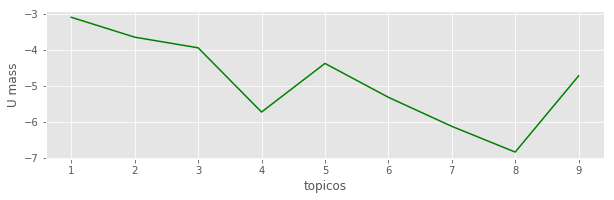

In [13]:
lmlist, c_v = evaluate_graph(dictionary=diccionario_p, corpus=corpus_p, texts=texts_p, limit=10)

In [20]:
# LDA MODE
lda_p = models.ldamodel.LdaModel(corpus=corpus_p, id2word =diccionario_p, num_topics=6, passes=500, iterations=10)

In [21]:
lda_p.print_topics()

[(0,
  '0.053*"nan" + 0.020*"social" + 0.019*"productividad" + 0.018*"produccion" + 0.016*"anos" + 0.014*"agricolas" + 0.012*"sociales" + 0.012*"pobreza" + 0.011*"vulnerabilidad" + 0.011*"edad"'),
 (1,
  '0.045*"jovenes" + 0.033*"nan" + 0.024*"acciones" + 0.021*"acceso" + 0.020*"social" + 0.020*"promover" + 0.017*"capital" + 0.017*"humano" + 0.016*"desarrollo" + 0.015*"joven"'),
 (2,
  '0.056*"indigenas" + 0.041*"indigena" + 0.026*"capacidades" + 0.019*"culturales" + 0.019*"publicas" + 0.018*"pueblos" + 0.015*"atencion" + 0.013*"acceso" + 0.012*"apoyo" + 0.011*"mujeres"'),
 (3,
  '0.054*"nan" + 0.016*"empleo" + 0.014*"economicos" + 0.013*"productividad" + 0.012*"recursos" + 0.011*"trabajo" + 0.011*"acuicolas" + 0.011*"especie" + 0.011*"colocacion" + 0.010*"social"'),
 (4,
  '0.043*"nan" + 0.023*"servicios" + 0.022*"social" + 0.020*"educacion" + 0.016*"capacidades" + 0.016*"salud" + 0.012*"acciones" + 0.011*"desarrollo" + 0.010*"familias" + 0.010*"alimentacion"'),
 (5,
  '0.039*"nan" + 

In [22]:
vis_data_p = gensimvis.prepare(lda_p, corpus_p, diccionario_p)
pyLDAvis.display(vis_data_p)
#pyLDAvis.save_html(vis_data_p,'vis.html')

Con este algoritmo fue capaz de identificar seis diferentes tópicos, con coherencia semántica suficente los cuales nombramos de la siguiente manera de acuerdo a las palabras que resultaron en cada tópico:
1. Educación y finanzas
2. Fortalecimiento agrícola y prevención de desastres
3. Servicios de vivienda y alimentación
4. Capital humano
5. Recursos económicos
6. Gestión jurídica

In [33]:
#import numpy as np
#import json
def add_topics_names(tlist, tnames, json_data):
    data1=json_data
    atop = len(data1['mdsDat']['topics'])
    assigned_names= np.arange(1, atop+1).tolist()
    for i,j in enumerate(tlist):
        assigned_names[j]=tnames[i]
    data1['mdsDat']['topic.names']=assigned_names
    return data1

#ldavis preffs
#topics_to_name = [0,1,2,3,4,5]
#topics_names = ["Apoyo a la juventud", "Educación", "Fortalecimiento Agrícola", "Microeconomía", "Gestión Jurídica", "Apoyo a viviendas"]

#loading saved json file
#with open('topicos.json') as data_file:    
#    data = json.load(data_file)
#Calling function change names
#data=add_topics_names(topics_to_name, topics_names, data)
#save json file
#with open('topicos_nombres.json', 'w') as fp:
#    json.dump(data, fp)

## Similitud

Por otro lado, para encontrar la similitud entre programas, es decir, generar medidas de distancia entre programas sociales de acuerdo al contenido de sus objetivos se utilizó un algoritmo llamado doc2vec. Es un algoritmo no supervisado para generar vectorares a partir de oraciones, palabras o documentos, es una representación numérica del documento. Los vectores generados a partir de doc2vec pueden ser utilizados para encontrar similitudes entre documentos. De esta manera, se genera un algoritmo que aprende de los textos de cada programa y es capaz de generar métricas de similitud entre programas como se muestra en la siguiente diagrama.

In [34]:
# Test and Train Dara
train_corpus = list(gen_corpus(df_p, stemming=False))
test_corpus = list(gen_corpus(df_p, tokens_only=True, stemming=False))

# Model
model = gensim.models.doc2vec.Doc2Vec(size=52, min_count=2, iter=55)
# Train model
model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.iter)

In [38]:
# Generate similarity matrix
similarities = [] 
mitad = int(round(len(train_corpus) / 2, 0))

for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn= len(model.docvecs))
    similarities.append(dict(sims))
    
# Get only lower matrix and replace with None's
similarities_df = pd.DataFrame(similarities)
similarities_df = pd.DataFrame(np.tril(similarities_df.values, k=-1))
similarities_df.index = df_p.index
similarities_df.columns = df_p.index
similarities_df['nombre_programa'] = df_p['nombre_programa']
similarities_df.replace(0, similarities_df.replace([0], [None]), inplace=True) 

In [41]:
#similarities_df.to_csv('similarities_df_triangular.csv')

In [42]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Document (40): «nacional forestal desarrollo forestal promover aprovechamiento sustentable recursos forestales pais reactivar economia forestal calidad habitantes forestales mantener incrementar provision servicios ambientales reducir emisiones carbono generadas deforestacion degradacion forestal considerando modelo intervencion basado vision regional territorio efecto subsidios otorga federacion comision nacional forestal mayores mejores impactos diversos ecosistemas habitan areas forestales pais nan promover aprovechamiento sustentable recursos forestales pais reactivar economia forestal calidad habitantes forestales mantener incrementar provision servicios ambientales reducir emisiones carbono generadas deforestacion degradacion forestal considerando modelo intervencion basado vision regional territorio efecto subsidios otorga federacion comision nacional forestal mayores mejores impactos diversos ecosistemas habitan areas forestales pais nan nan nan nan nan nan»

SIMILAR/DISSIMILAR

## Referencias

- Blei et al., "Latent Dirichlet Allocation", 2003
- CONEVAL, Evaluación de la Política Social 2016
- CONEVAL, Inventario Federal de Programas y Acciones Federales de Desarrollo Social, 2014 